# **Relational-based Transfer Learning for Automatic Optical Inspection based on domain discrepancy**

This notebook complements the research paper presented in [SPIE COS Phonotics Asia 2022](https://spie.org/spie-cos-photonics-asia/presentation/Relational-based-transfer-learning-for-automatic-optical-inspection-based-on/12317-42?SSO=1)

<a href="https://colab.research.google.com/drive/1qw5F_V8FH2yorPPX8H6_BKFIPiqhFyB3?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dowload short datasets (DC-1 and LC-101) and load libraries

In [1]:
!wget https://yolov5defects.s3.us-west-1.amazonaws.com/dc-1.zip
!unzip dc-1.zip
!rm -rf dc-1.zip
!wget https://yolov5defects.s3.us-west-1.amazonaws.com/lc-101.zip
!unzip lc-101.zip
!rm -rf lc-101.zip
!wget https://yolov5defects.s3.us-west-1.amazonaws.com/gini_all.csv
!wget https://yolov5defects.s3.us-west-1.amazonaws.com/EMD_all.csv
!wget https://yolov5defects.s3.us-west-1.amazonaws.com/datasets_overview.csv
!wget https://yolov5defects.s3.us-west-1.amazonaws.com/dds_all.csv

--2022-11-18 09:38:49--  https://yolov5defects.s3.us-west-1.amazonaws.com/dc-1.zip
Resolving yolov5defects.s3.us-west-1.amazonaws.com (yolov5defects.s3.us-west-1.amazonaws.com)... 52.219.120.185
Connecting to yolov5defects.s3.us-west-1.amazonaws.com (yolov5defects.s3.us-west-1.amazonaws.com)|52.219.120.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15521886 (15M) [application/zip]
Saving to: ‘dc-1.zip’

dc-1.zip            100%[===================>]  14.80M  21.6MB/s    in 0.7s    

2022-11-18 09:38:50 (21.6 MB/s) - ‘dc-1.zip’ saved [15521886/15521886]

Archive:  dc-1.zip
   creating: dc-1/images/
   creating: dc-1/images/val/
  inflating: dc-1/images/val/dongci_lw_00282.jpg  
  inflating: dc-1/images/val/dongci_lw_00291.jpg  
  inflating: dc-1/images/val/dongci_lw_00309.jpg  
  inflating: dc-1/images/val/dongci_lw_00310.jpg  
  inflating: dc-1/images/val/dongci_lw_00319.jpg  
  inflating: dc-1/images/val/dongci_lw_00326.jpg  
  inflating: dc-1/images/val

### Import libraries

In [2]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import urllib
import PIL.Image as Image
import cv2
from IPython.display import display
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 10, 10
np.random.seed(seed=42)
import os
import shutil
from xml.etree import cElementTree as ElementTree
from sklearn.cluster import KMeans
from scipy.optimize import minimize
import pandas as pd

Although we cannot use full-sized datasets in this implementation, we can look at each defect category and different datasets.

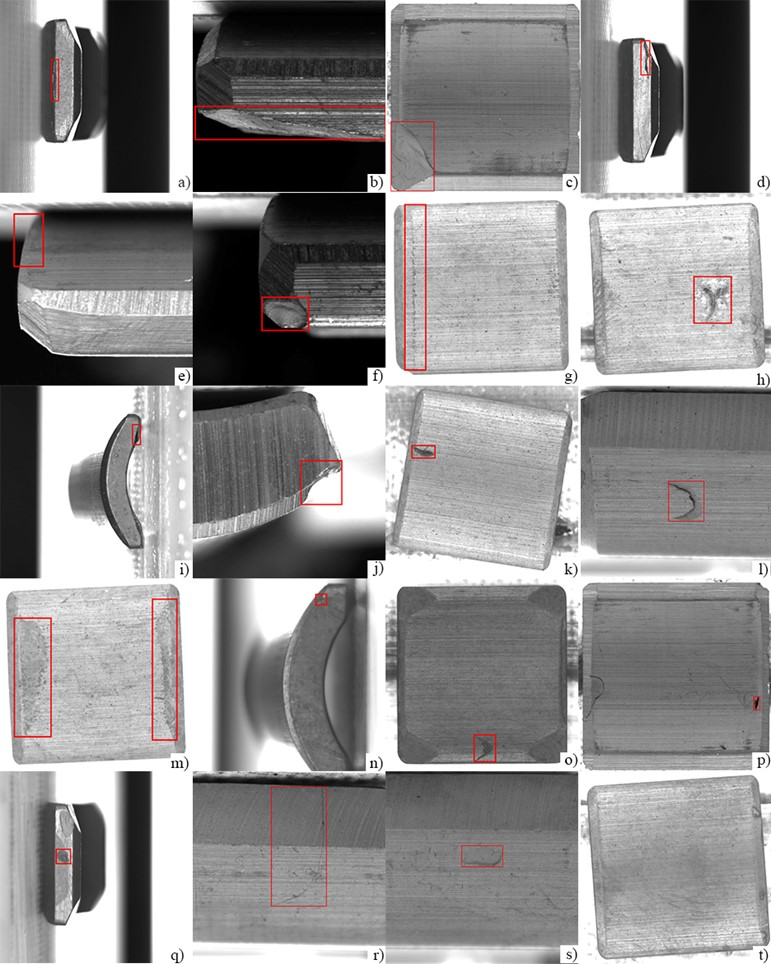

*Figure 1. Examples of defect classes: a) white crack, b) standard chipping, c) standard crack, d) chamfer, e) multifaceted, f) crystallization, g) contour chipping, h) contour chipping, i) membrane chipping, j) ambiguity, k) plane chipping, l) light inking, m) triangular row, n) bump, o) fine cracks, p) impurities, q) chipping, r) abnormal chamfer, s) membrane chipping, t) bump.*

**Recall**. We used a group of real-world class-imbalanced datasets containing 47561 gray-scale images with 20 different defect categories manually labeled arranged in 11 magnetic tile datasets, as shown below.

In [3]:
datasets=pd.read_csv('datasets_overview.csv')
datasets

,Dataset,Samples,images,_bailiewen,_biaozhunbengque,_biaozhunliewen,_daojiao,duocengmian,_jiejing,_lunkuobengque,...,_qianmo,_sanjiaolie,_tudian,_xixiaoliewen,_zazhi,bengque,daojiaoyichang,liewen,qikong,wuzi
0,dc-1,385,252,0,0,349,0,2,0,0,...,0,0,0,18,10,0,0,0,0,0
1,jy-381-2,3165,3154,0,3041,62,1,3,0,10,...,0,0,0,0,0,34,6,2,0,0
2,jy-381-4,2464,2443,0,1676,250,212,0,0,325,...,0,0,0,0,0,0,0,0,0,0
3,lc-101,9486,7008,0,3875,2178,84,2778,0,183,...,0,0,0,315,64,0,0,0,0,2
4,lc-201,6171,5294,0,4070,631,393,294,0,744,...,8,0,0,2,8,0,0,0,0,0
5,nj-101,5796,5134,0,1021,3058,1,705,0,27,...,0,0,0,119,850,0,0,0,0,0
6,nj-201,6873,6293,0,1944,2787,2,762,0,561,...,26,0,0,101,645,0,0,0,0,0
7,xh-1,5444,4946,0,3102,1403,40,373,14,5,...,1,4,0,146,73,0,0,0,0,0
8,xh-2,3040,2792,267,1515,1002,0,138,4,94,...,0,0,0,3,15,0,0,0,0,0
9,xh-3,2835,2542,0,1209,341,0,272,234,79,...,338,0,26,2,328,0,0,0,0,0


# Overview of our domain similarity and adaptation scheme.
The system consisted of five parts. (1) The source dataset scoring executed the domain discrepancy analysis to select a source domain dataset from the repository close to the target dataset regarding EMD distance, categories overlapping, and the Gini score. (2) The domain adaptation algorithm minimized the divergence between domains by removing samples from the source dataset to match as many categories as possible. (3) Data augmentation mitigated the data imbalance among categories by increasing the number of samples in the minority classes and removing elements from the majority classes. (4) Pretraining the network on the selected sub-dataset using benchmark pre-trained weights. (5) Transference of the best pre-trained weights that belong to the network backbone to the target network as initialized the rest randomly. Then, trained the last network using a data-augmented target dataset.

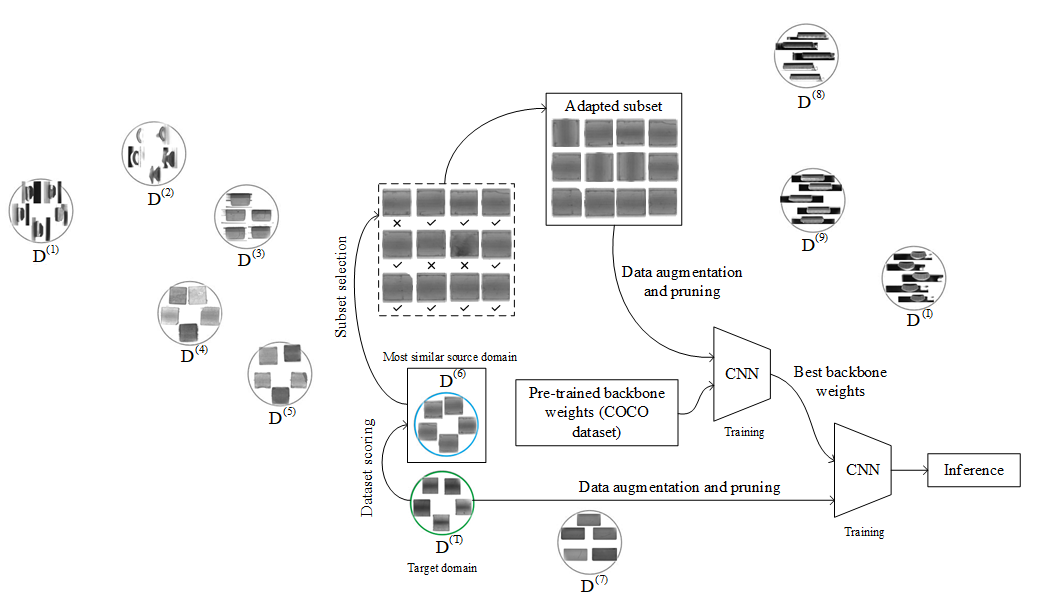

Since the full-size datasets are not public, we will implement the algorithms using images extracted from two reduced datasets.

In [4]:
folder1='dc-1/images/val/'
folder2='lc-101/images/val/'
defects1=[]
defects2=[]
data_files1 = [x[2] for x in os.walk(folder1)]
data_files2 = [y[2] for y in os.walk(folder2)]
for i in range(0,len(data_files1[0])):
    if data_files1[0][i][-3:]=='jpg':
        buffer=data_files1[0][i]
        defects1.append(buffer)
for i in range(0,len(data_files2[0])):
    if data_files2[0][i][-3:]=='jpg':
        buffer=data_files2[0][i]
        defects2.append(buffer)
defects1.sort()
defects2.sort()

# Plotting an image and its k-means

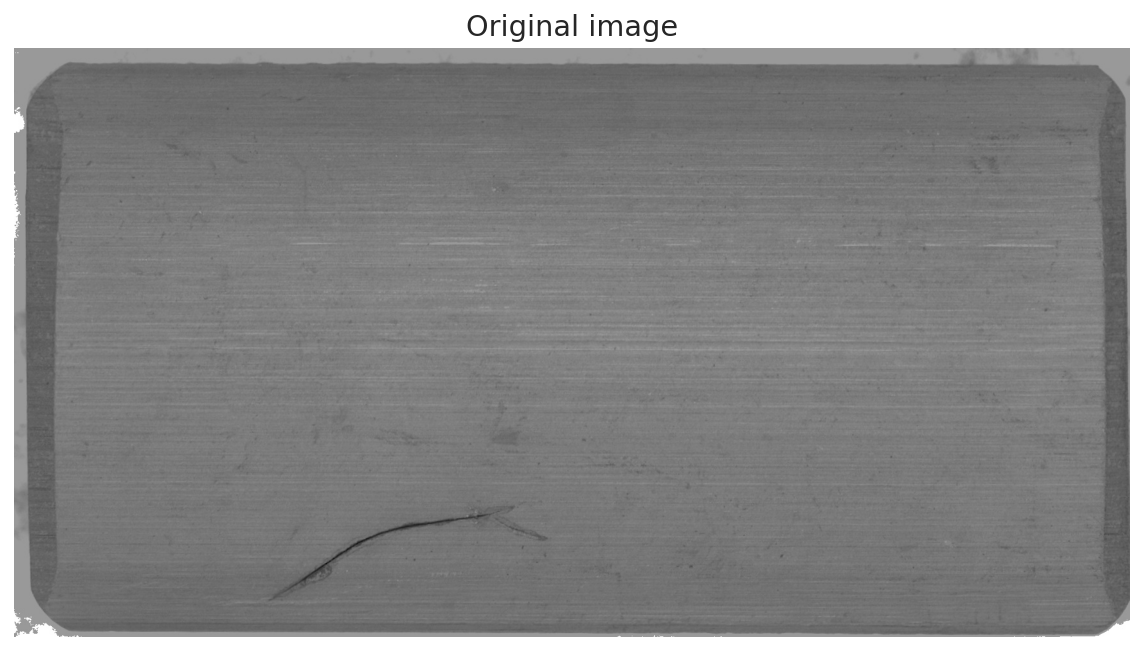

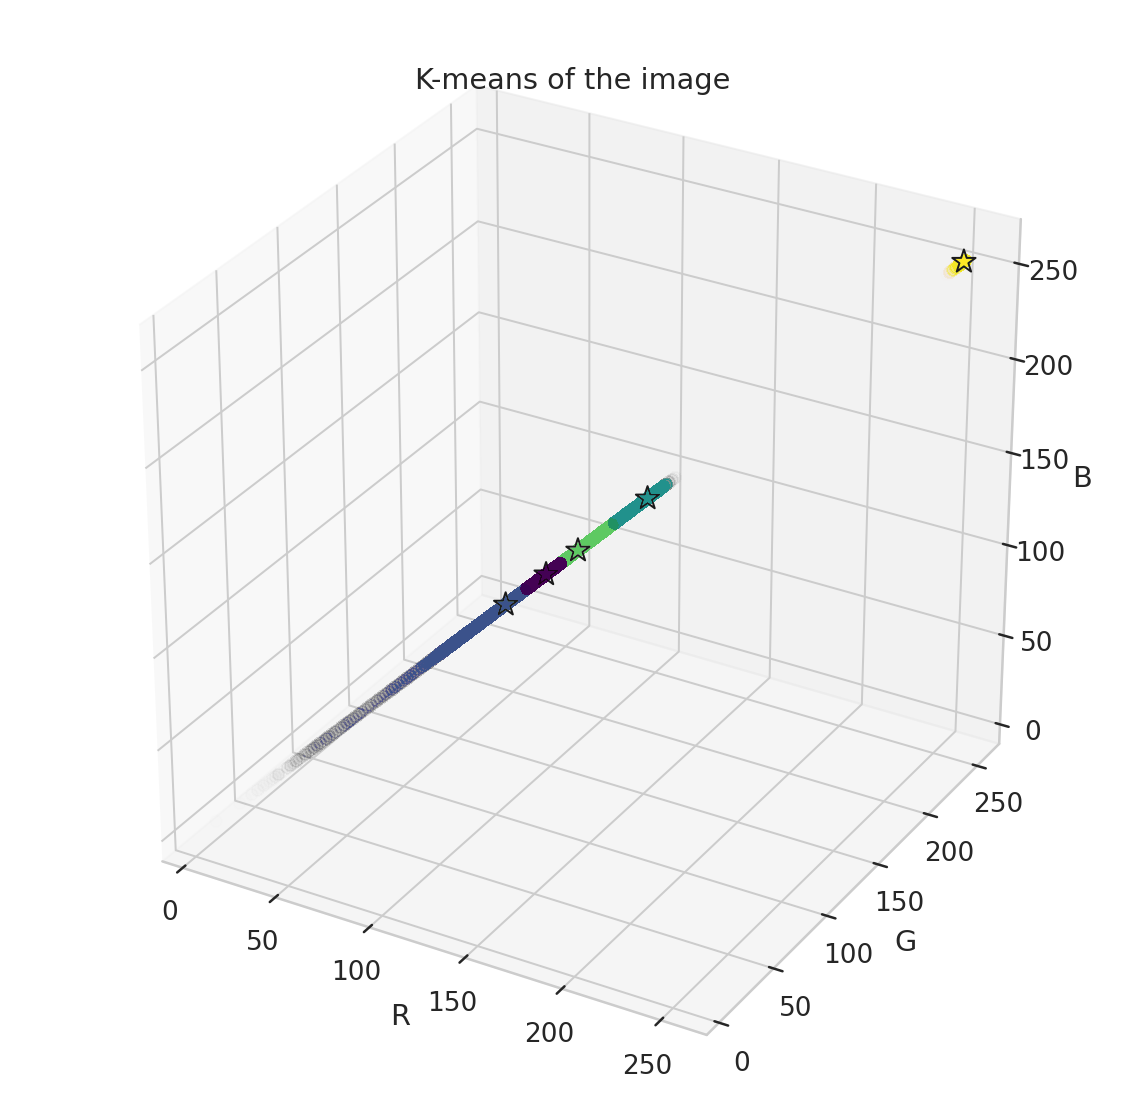

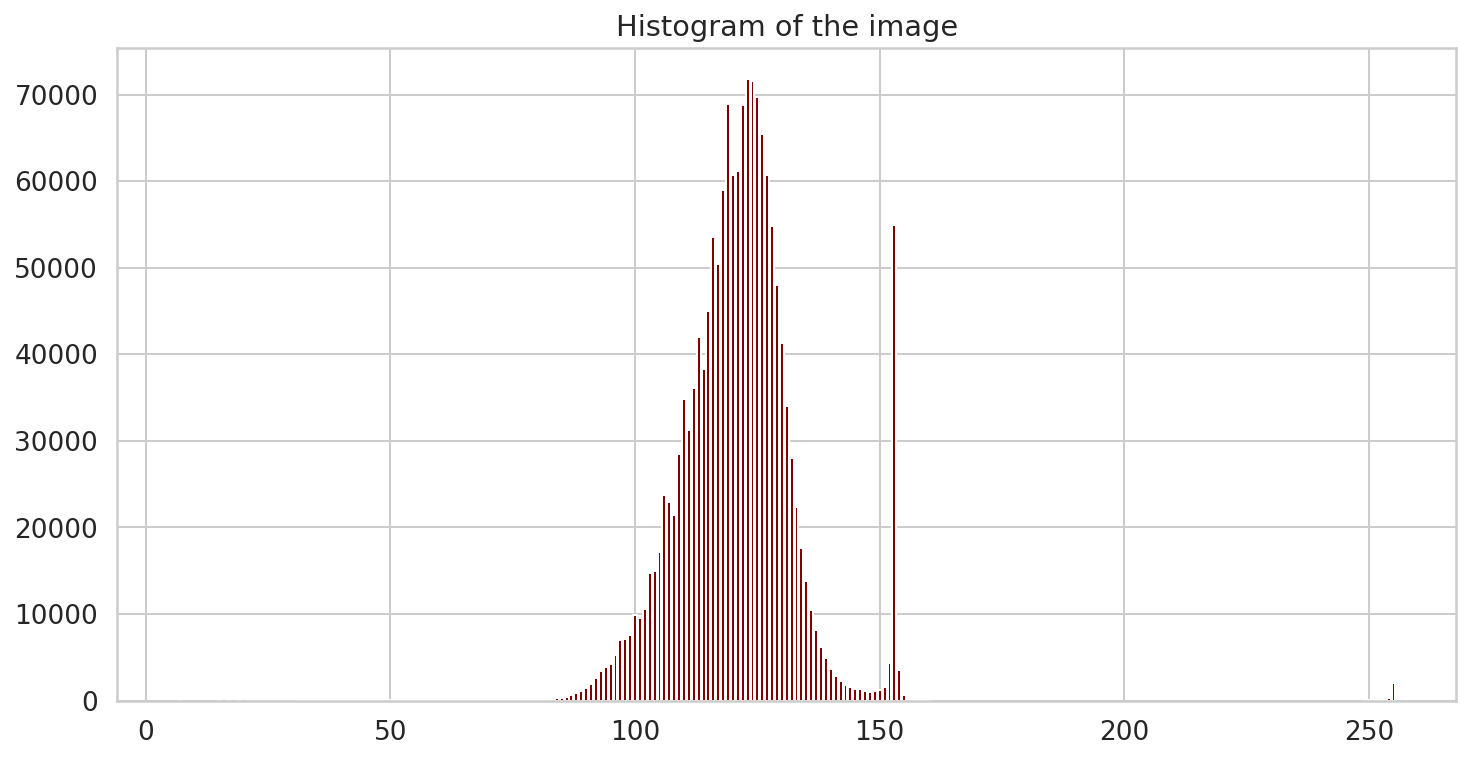

In [5]:
img=cv2.imread(cv2.samples.findFile(folder1+defects1[0]))
# Then, we will see the image dimensions
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
a = np.asarray(img,dtype=np.float32)/255
plt.imshow(a)
plt.axis('off')
plt.title('Original image')
plt.show()
x, y, z = a.shape
a1 = a.reshape(x*y, z)
n = 5
k_means = KMeans(init="k-means++", n_clusters=n, n_init=10, random_state=0)
k_means.fit(a1)
centroids = k_means.cluster_centers_
labels = k_means.labels_
a2 = centroids[labels]
a3 = a2.reshape(x,y,z)
ax = plt.axes(projection='3d')
R,G,B=cv2.split(img)
x,y,z=[],[],[]
for i in range(len(centroids)):
    x.append(255*centroids[i][0])
    y.append(255*centroids[i][1])
    z.append(255*centroids[i][2])
ax.scatter3D(x, y, z,edgecolor='k',marker='*',s=150,alpha=1,color='white');
ax.scatter3D(R, G, B, c=labels, cmap='viridis', s=35, alpha = 0.002);
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
ax.autoscale(enable=True, axis='x', tight=True) 
plt.title('K-means of the image')
plt.figure(figsize=(12,6))
unique, counts = np.unique(R, return_counts=True)
plt.bar(unique, counts, color ='maroon')
plt.title('Histogram of the image')
plt.show()

### Calculating the elbow curve
The elbow method runs k-means clustering on the dataset for a range of values of k. For each of the K values, we calculate average distances to the centroid across all data points and find the point where the average length from the centroid falls. In this case, a proper k value is 6, but we chose k=5 for the overall dataset.

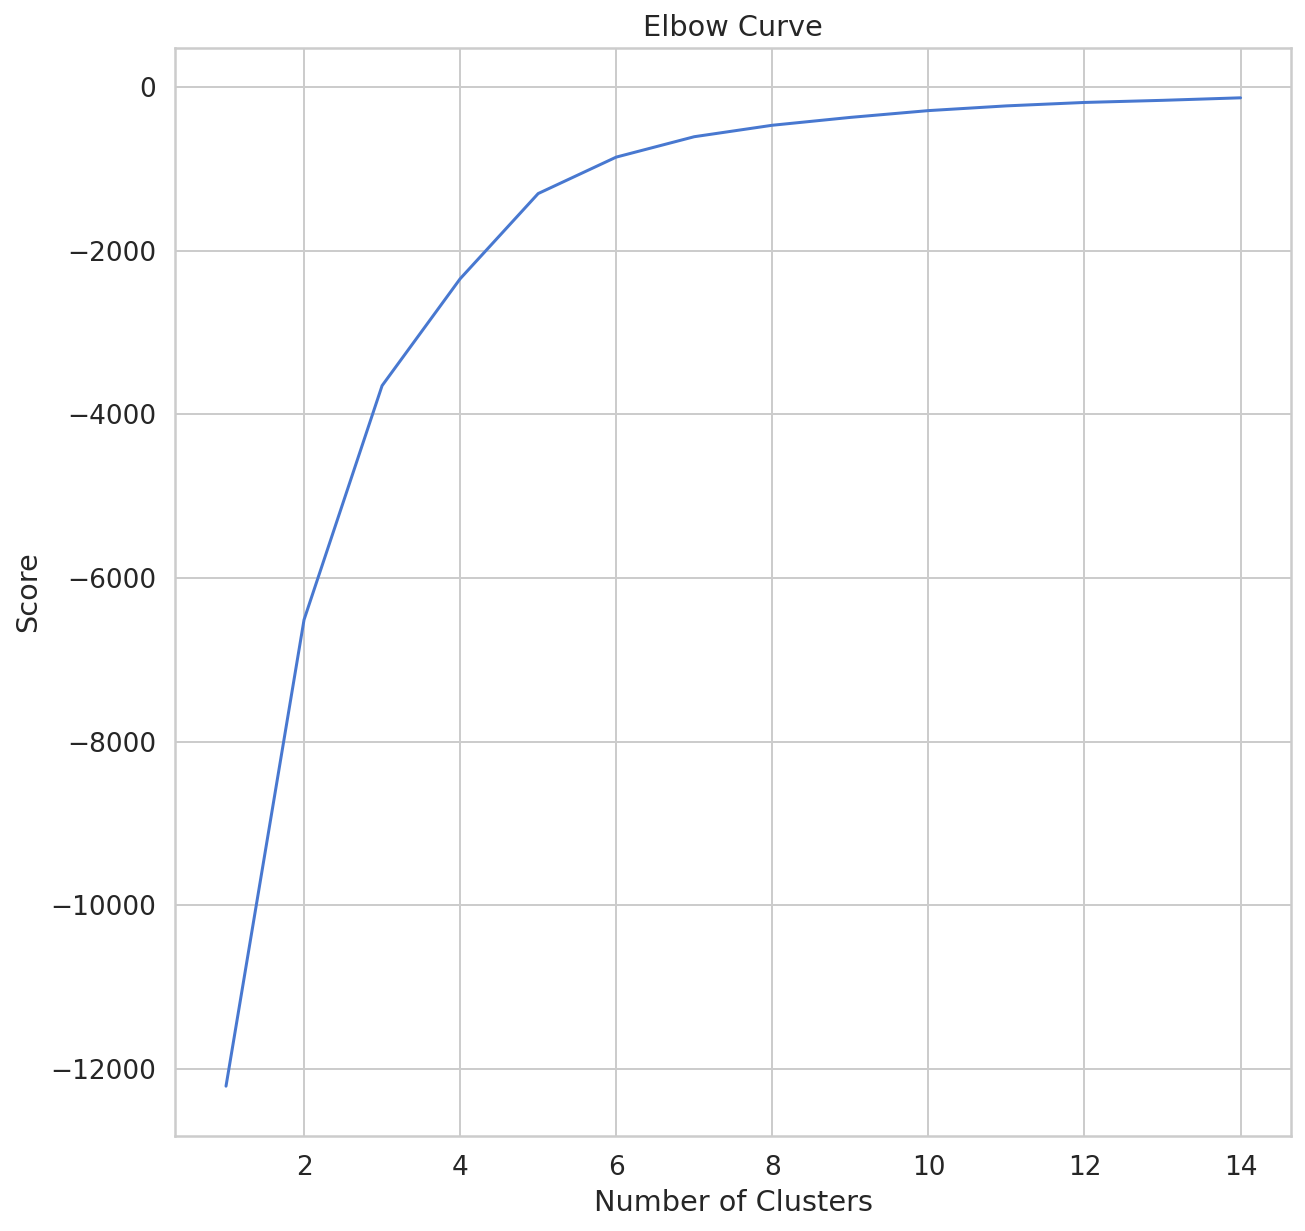

In [6]:
img=cv2.imread(cv2.samples.findFile(folder1+defects1[0]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
a = np.asarray(img,dtype=np.float32)/255
x, y, z = a.shape
a1 = a.reshape(x*y, z)
n = range(1, 15)
k_means = [KMeans(init="k-means++", n_clusters=i, n_init=10, random_state=0) for i in n]
score=[k_means[i].fit(a1).score(a1) for i in range(len(k_means))]
plt.plot(n,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

## Algorithm to calculate the K-means of the full dataset

#### DC-1

In [7]:
cds=[] #centroids
cnt=[] #number of elements that belong to the closest k mean centroid (weights)
n = 5 #
for i in tqdm(range(len(defects1))):
    img=cv2.imread(cv2.samples.findFile(folder1+defects1[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    a = np.asarray(img,dtype=np.float32)/255
    x, y, z = a.shape
    a1 = a.reshape(x*y, z)
    k_means = KMeans(n_clusters=n)
    k_means.fit(a1)
    centroids = k_means.cluster_centers_
    cds.append(255*centroids)
    labels = k_means.labels_
    _, counts = np.unique(labels, return_counts=True)
    cnt.append(counts/len(labels))
cds1=np.copy(cds)
cnt1=np.copy(cnt)

100%|██████████| 40/40 [05:38<00:00,  8.46s/it]


For example, the k-means of image dongci_lw_00282.jpg are:

In [8]:
i=0
print(defects1[i])
print(cds1[i][0][0], cds1[i][1][0], cds1[i][2][0], cds1[i][3][0], cds1[i][4][0])

dongci_lw_00282.jpg
150.85251 118.208374 104.627846 128.45546 254.58342


And its respective weights:

In [9]:
print('sum(',cnt1[i],') =',sum(cnt1[i]))

sum( [0.05321864 0.4123814  0.18233579 0.3503782  0.00168598] ) = 1.0


#### LC-101

In [10]:
cds=[] #centroids
cnt=[] #number of elements that belong to the closest k mean centroid (weights)
n = 5 #
for i in tqdm(range(len(defects2))):
    img=cv2.imread(cv2.samples.findFile(folder2+defects2[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    a = np.asarray(img,dtype=np.float32)/255
    x, y, z = a.shape
    a1 = a.reshape(x*y, z)
    k_means = KMeans(n_clusters=n)
    k_means.fit(a1)
    centroids = k_means.cluster_centers_
    cds.append(255*centroids)
    labels = k_means.labels_
    _, counts = np.unique(labels, return_counts=True)
    cnt.append(counts/len(labels))
cds2=np.copy(cds)
cnt2=np.copy(cnt)

100%|██████████| 40/40 [05:33<00:00,  8.33s/it]


For example, the k-means of image 011413-0941-892-130-101_ng.jpg are:



In [11]:
i=0
print(defects2[i])
print(cds2[i][0][0], cds2[i][1][0], cds2[i][2][0], cds2[i][3][0], cds2[i][4][0])

011413-0941-892-130-101_ng.jpg
109.45452 185.13995 150.38121 253.1163 128.90266


And its respective weights:

In [12]:
print('sum(',cnt2[i],') =',sum(cnt2[i]))

sum( [0.35237603 0.08840182 0.17738537 0.0587949  0.32304188] ) = 1.0


### Calculate the average k-means
- The average k-means centroids should be according to the total number of occurrences rather than a mean from each image.

In [13]:
R,G,B=np.zeros((len(cds1),n)),np.zeros((len(cds1),n)),np.zeros((len(cds1),n))
for i in tqdm(range(len(cds1))): #our image is in gray-scale, so we must assign the same value to each channel
    for j in range(n):
        R[i][j]=cds1[i][j][0]
        G[i][j]=cds1[i][j][1]
        B[i][j]=cds1[i][j][2]
Ra,Ga,Ba=sum(R)/len(R),sum(G)/len(G),sum(B)/len(B)
print('Average Red by cluster:',Ra)
print('Average Green by cluster:',Ga)
print('Average Blue by cluster:',Ba)

100%|██████████| 40/40 [00:00<00:00, 38541.73it/s]

Average Red by cluster: [102.70239143 140.20943432 144.85152016 130.13676996 156.52292995]
Average Green by cluster: [102.70239143 140.20943432 144.85152016 130.13676996 156.52292995]
Average Blue by cluster: [102.70239143 140.20943432 144.85152016 130.13676996 156.52292995]


## The Earth-Mover distance

### Dantzig-Algorithm-for-Earth-Mover-s-Distance-Wasserstein-
Given the Earth Mover's Distance (Wasserstein distance) model, Dantzig's algorithm proposes its initial parameters initialization by following the method in the paper below.

Russell, E. J. (1969). Extension of Dantzig’s Algorithm to Finding an Initial Near-Optimal Basis for the Transportation Problem. Operations Research, 17(1), 187–191. http://www.jstor.org/stable/168855



In [14]:
def dantzig(costin,X,Y):
    A=np.copy(X)
    B=np.copy(Y)
    cost=np.copy(costin)
    initial=np.zeros_like(cost)
    c=0
    col, row=[],[]
    while np.any(cost) and c!=np.product(cost.shape):
        w=[]
        y=[]
        #step 1
        for i in range(len(cost)):
            y.append(np.max(cost[:,i]))
            w.append(np.max(cost[i]))
        #step 2
        s2=np.zeros_like(cost)
        for i in range(cost.shape[0]):
            for j in range(cost.shape[1]):
                s2[i][j]=w[i]+y[j]-cost[i][j]
        #clean up the s2
        for i in range(len(col)):
            s2[:,col[i]]=np.zeros_like(s2[:,col[i]])
        for i in range(len(row)):
            s2[row[i]]=np.zeros_like(s2[row[i]])
        #step 3
        xdij=np.max(s2)
        coord=np.where(s2==xdij)
        if A[coord[0][0]]>=B[coord[1][0]]: #if row is higher than column a>b
            value=B[coord[1][0]]
            cost[:,coord[1][0]]=np.zeros_like(cost[:,coord[1][0]])# "delete" column
            col.append(coord[1][0])
            B[coord[1][0]]=0
            A[coord[0][0]]=A[coord[0][0]]-value
        else: # b>=a
            value=A[coord[0][0]]
            cost[coord[0][0]]=np.zeros_like(cost[coord[0][0]])#"delete" row
            row.append(coord[0][0])
            A[coord[0][0]]=0
            B[coord[1][0]]=B[coord[1][0]]-value
        initial[coord[0][0]][coord[1][0]]=value
        c=c+1
        #print(value)
    return initial

### Setting up the optimization model

In [15]:
def wasserstein(cen1,cen2,a,b):
    def objective(x):
        minim=0
        for i in range(costo.shape[0]):
            for j in range(costo.shape[1]):
                minim=minim+costo[i][j]*x[i*(5)+j]
        return minim
    def constraint0(x): #The number of constraints may vary as per the clusters K you have per dataset
        a0m=a[0]
        for j in range(costo.shape[0]):
            a0m=a0m-x[0*(len(costo))+j]
        return a0m
    def constraint1(x):
        a1m=a[1]
        for j in range(costo.shape[0]):
            a1m=a1m-x[1*(len(costo))+j]
        return a1m
    def constraint2(x):
        a2m=a[2]
        for j in range(costo.shape[0]):
            a2m=a2m-x[2*(len(costo))+j]
        return a2m
    def constraint3(x):
        a3m=a[3]
        for j in range(costo.shape[0]):
            a3m=a3m-x[3*(len(costo))+j]
        return a3m
    def constraint4(x):
        a4m=a[4]
        for j in range(costo.shape[0]):
            a4m=a4m-x[4*(len(costo))+j]
        return a4m
    def constraint5(x):
        b0m=b[0]
        for j in range(costo.shape[0]):
            b0m=b0m-x[(j*5)]
        return b0m
    def constraint6(x):
        b1m=b[1]
        for j in range(costo.shape[0]):
            b1m=b1m-x[(j*5+1)]
        return b1m
    def constraint7(x):
        b2m=b[2]
        for j in range(costo.shape[0]):
            b2m=b2m-x[(j*5+2)]
        return b2m
    def constraint8(x):
        b3m=b[3]
        for j in range(costo.shape[0]):
            b3m=b3m-x[(j*5+3)]
        return b3m
    def constraint9(x):
        b4m=b[4]
        for j in range(costo.shape[0]):
            b4m=b4m-x[(j*5+4)]
        return b4m
    n1=len(a)
    n2=len(b)
    costo=np.zeros((n1,n2))
    for i in range(n1):
        for j in range(n2):
            costo[i][j]=np.linalg.norm(cen1[i]-cen2[j]) #Euclidean distance
    result=dantzig(costo,a,b)
    x0=result.flatten()
    bn=(0, None)
    bnds=(bn,bn,bn,bn,bn,bn,bn,bn,bn,bn,bn,bn,bn,bn,bn,bn,bn,bn,bn,bn,bn,bn,bn,bn,bn)
    con0={'type':'eq','fun':constraint0}
    con1={'type':'eq','fun':constraint1}
    con2={'type':'eq','fun':constraint2}
    con3={'type':'eq','fun':constraint3}
    con4={'type':'eq','fun':constraint4}
    con5={'type':'eq','fun':constraint5}
    con6={'type':'eq','fun':constraint6}
    con7={'type':'eq','fun':constraint7}
    con8={'type':'eq','fun':constraint8}
    con9={'type':'eq','fun':constraint9}
    cons=[con0,con1,con2,con3,con4,con5,con6,con7,con8,con9]
    sol=minimize(objective,x0,method='SLSQP', bounds=bnds, constraints=cons)
    test=np.reshape(sol.x, (5,5))
    wd=sum(sum(costo*test))/sum(sol.x)
    return wd

Let's compute the EMD between two images of datasets DC-1 and LC-101

In [16]:
u=0 # index to select an image from the DC-1 dataset
v=0 # index to select an image from the LC-101 dataset
a=cnt1[u].copy()
b=cnt2[v].copy()
cen1=cds1[u].copy()
cen2=cds2[v].copy()
EMD_test=wasserstein(cen1,cen2,a,b)
print('The EMD of image',defects1[u],'(DC-1) and',defects2[v],'(LC-101) is:',EMD_test)

The EMD of image dongci_lw_00282.jpg (DC-1) and 011413-0941-892-130-101_ng.jpg (LC-101) is: 34.3403988486407


In general, the EMD for all datasets are as follows:

In [17]:
EMD_all=pd.read_csv('EMD_all.csv')
EMD_all

,target/source,dc-1,jy-381-2,jy-381-4,lc-101,lc-201,nj-101,nj-201,xh-1,xh-2,xh-3,xh-4,sum
0,dc-1,0.000000,58.267363,58.170956,29.159085,53.679435,23.975349,75.512932,55.907650,81.297558,72.942607,94.462611,603.375545
1,jy-381-2,58.267363,0.000000,38.763930,68.237752,22.698803,63.032794,105.659656,87.783601,104.980347,104.829218,123.612636,777.866099
2,jy-381-4,58.170956,38.763930,0.000000,58.207986,19.988077,54.854490,68.100466,53.964180,66.216417,66.923914,84.848706,570.039120
3,lc-101,29.159085,68.237752,58.207986,0.000000,57.495571,12.319988,48.334013,27.251809,63.205256,43.831487,71.926717,479.969665
4,lc-201,53.679435,22.698803,19.988077,57.495571,0.000000,52.276515,86.244480,69.610405,82.281544,82.130416,103.677855,630.083100
5,nj-101,23.975349,63.032794,54.854490,12.319988,52.276515,0.000000,56.560110,35.317050,64.618443,51.874802,75.604734,490.434276
6,nj-201,75.512932,105.659656,68.100466,48.334013,86.244480,56.560110,0.000000,25.228231,19.264159,17.573035,25.677780,528.154861
7,xh-1,55.907650,87.783601,53.964180,27.251809,69.610405,35.317050,25.228231,0.000000,39.009281,17.045618,46.599446,457.717270
8,xh-2,81.297558,104.980347,66.216417,63.205256,82.281544,64.618443,19.264159,39.009281,0.000000,28.351578,19.857730,569.082314
9,xh-3,72.942607,104.829218,66.923914,43.831487,82.130416,51.874802,17.573035,17.045618,28.351578,0.000000,29.735132,515.237807


# The Gini coefficient

It measures the long-tailedness of data that can effectively differentiate long-tailed and balanced datasets. The reason is that it is not affected by extreme samples, the absolute number of data, and has a bounded distribution (0,1).

**We will calculate the Gini coefficient of LC-101 and JY-381-2 adapted to dataset DC-1**.

In [18]:
gini_example=datasets[datasets["Dataset"].str.contains("dc-1|jy-381-2|lc-101")].filter(["Dataset", "_bailiewen", "_biaozhunbengque","_biaozhunliewen","_daojiao","duocengmian","_jiejing","_lunkuobengque","_mohubengque","_molengliangke","_pingmianbengque","_qianmo","_sanjiaolie","_tudian","_xixiaoliewen","_zazhi","bengque","daojiaoyichang","liewen","qikong","wuzi"])
gini_example

,Dataset,_bailiewen,_biaozhunbengque,_biaozhunliewen,_daojiao,duocengmian,_jiejing,_lunkuobengque,_mohubengque,_molengliangke,...,_qianmo,_sanjiaolie,_tudian,_xixiaoliewen,_zazhi,bengque,daojiaoyichang,liewen,qikong,wuzi
0,dc-1,0,0,349,0,2,0,0,0,2,...,0,0,0,18,10,0,0,0,0,0
1,jy-381-2,0,3041,62,1,3,0,10,6,0,...,0,0,0,0,0,34,6,2,0,0
3,lc-101,0,3875,2178,84,2778,0,183,3,2,...,0,0,0,315,64,0,0,0,0,2


Step 1: Compute the normalized cumulative distribution $\mathbb{C}_i$, assuming that k categories and their respective number samples $m_i,(i=1,2,…,\mathbb{k})$ are in ascending order:

$$\mathbb{C_i}=\frac{1}{\mathbb{k}}\sum_{j=1}^{i}m_j$$

In [19]:
mi_dc_1=list(gini_example.iloc[0, [3,5,9,10,14,15]])
mi_jy_381_2=list(gini_example.iloc[1, [3,5,9,10,14,15]])
mi_lc_101=list(gini_example.iloc[2, [3,5,9,10,14,15]])

mi_dc_1.sort()
mi_jy_381_2.sort()
mi_lc_101.sort()

k_dc_1=sum(mi_dc_1)
k_jy_381_2=sum(mi_jy_381_2)
k_lc_101=sum(mi_lc_101)

Ci_dc_1=[0]
Ci_jy_381_2=[0]
Ci_lc_101=[0]

for i in range(1,len(mi_dc_1)+1):
  Ci_dc_1.append((Ci_dc_1[i-1]+mi_dc_1[i-1]))
  Ci_jy_381_2.append((Ci_jy_381_2[i-1]+mi_jy_381_2[i-1]))
  Ci_lc_101.append((Ci_lc_101[i-1]+mi_lc_101[i-1]))
Ci_dc_1=Ci_dc_1/k_dc_1
Ci_jy_381_2=Ci_jy_381_2/k_jy_381_2
Ci_lc_101=Ci_lc_101/k_lc_101

print("Cumulative distribution for dc-1 using the categories belonging to dc-1")
print(Ci_dc_1)
print("Cumulative distribution for jy-381 using the categories belonging to dc-1")
print(Ci_jy_381_2)
print("Cumulative distribution for lc-101 using the categories belonging to dc-1")
print(Ci_lc_101)

Cumulative distribution for dc-1 using the categories belonging to dc-1
[0.         0.00519481 0.01038961 0.02077922 0.04675325 0.09350649
 1.        ]
Cumulative distribution for jy-381 using the categories belonging to dc-1
[0.         0.         0.         0.         0.         0.04615385
 1.        ]
Cumulative distribution for lc-101 using the categories belonging to dc-1
[0.00000000e+00 3.74601985e-04 7.49203971e-04 1.27364675e-02
 7.17362802e-02 4.79677842e-01 1.00000000e+00]


Step 2: Calculate the area B under the Lorenz Curve $L(x),x∈[0,1]$
$$B=\sum_{i=1}^{\mathbb{k}}\frac{\mathbb{C}_i+\mathbb{C}_{i-1}}{2}\frac{1}{\mathbb{k}}$$
$$A=0.5-B$$

In [20]:
B_dc_1=0
B_jy_381_2=0
B_lc_101=0

k_dc_1=6 #number of categories in DC-1 matching DC-1
k_jy_381_2=2 #number of categories in JY-381-2 matching DC-1
k_lc_101=6 #number of categories in LC-101 matching DC-1

for i in range(1,len(Ci_dc_1)):
  B_dc_1=B_dc_1+(Ci_dc_1[i]+Ci_dc_1[i-1])/2
  B_jy_381_2=B_jy_381_2+(Ci_jy_381_2[i]+Ci_jy_381_2[i-1])/2
  B_lc_101=B_lc_101+(Ci_lc_101[i]+Ci_lc_101[i-1])/2

B_dc_1=B_dc_1/k_dc_1
A_dc_1=0.5-B_dc_1
print("For DC-1:", "A =",A_dc_1,", B =",B_dc_1)

B_jy_381_2=B_jy_381_2/k_jy_381_2
A_jy_381_2=0.5-B_jy_381_2
print("For JY-381-2:", "A =",A_jy_381_2,", B =",B_jy_381_2)

B_lc_101=B_lc_101/k_lc_101
A_lc_101=0.5-B_lc_101
print("For LC-101:", "A =",A_lc_101,", B =",B_lc_101)

For DC-1: A = 0.3872294372294372 , B = 0.11277056277056278
For JY-381-2: A = 0.2269230769230769 , B = 0.2730769230769231
For LC-101: A = 0.3224542673409502 , B = 0.1775457326590498


**Step 3**. Estimate the Gini coefficient.
$$\delta=\frac{A}{A+B}$$

In [21]:
delta_dc_1=A_dc_1/(A_dc_1+B_dc_1)
print("Gini c. for DC-1 matching cats. from DC-1 =",delta_dc_1)
delta_jy_381_2=A_jy_381_2/(A_jy_381_2+B_jy_381_2)
print("Gini c. for JY-381-2 matching cats. from DC-1 =",delta_jy_381_2)
delta_lc_101=A_lc_101/(A_lc_101+B_lc_101)
print("Gini c. for LC-101 matching cats. from DC-1 =",delta_lc_101)

Gini c. for DC-1 matching cats. from DC-1 = 0.7744588744588744
Gini c. for JY-381-2 matching cats. from DC-1 = 0.4538461538461538
Gini c. for LC-101 matching cats. from DC-1 = 0.6449085346819003


Finally, we can look all gini coefficients reported in the paper:

In [22]:
gini_all=pd.read_csv('gini_all.csv')
gini_all

,target/source,dc-1,jy-381-2,jy-381-4,lc-101,lc-201,nj-101,nj-201,xh-1,xh-2,xh-3,xh-4
0,dc-1,0.774459,0.453846,0.000000,0.644909,0.663248,0.646976,0.580033,0.672870,0.673575,0.424101,0.570197
1,jy-381-2,0.494302,0.871055,0.562175,0.539080,0.591623,0.657294,0.541865,0.632601,0.572010,0.561765,0.728806
2,jy-381-4,0.000000,0.786667,0.562175,0.622363,0.577057,0.693048,0.559940,0.628049,0.521144,0.594363,0.639586
3,lc-101,0.774459,0.820845,0.562175,0.723363,0.725512,0.708316,0.614965,0.740811,0.687200,0.631817,0.777564
4,lc-201,0.739426,0.820845,0.562175,0.662683,0.751240,0.676215,0.648989,0.744124,0.687200,0.533243,0.779853
5,nj-101,0.774459,0.820845,0.562175,0.696078,0.725512,0.708316,0.614965,0.740811,0.687200,0.631817,0.777564
6,nj-201,0.739426,0.820845,0.562175,0.662683,0.751240,0.676215,0.648989,0.744124,0.687200,0.533243,0.779853
7,xh-1,0.774459,0.820845,0.562175,0.696078,0.751240,0.708316,0.648989,0.795993,0.724261,0.558526,0.807515
8,xh-2,0.691953,0.785650,0.566163,0.578939,0.707575,0.586141,0.506002,0.688813,0.708918,0.553282,0.737954
9,xh-3,0.745407,0.785650,0.566163,0.631251,0.742146,0.637612,0.562291,0.747312,0.724261,0.589322,0.774515


# Domain discrepancy score
We propose a function that consists of the product of the EMD and the Gini score divided by the set cardinality of the label space intersection of the target and the source tasks to describe the similarity across datasets.


$$disc(D^{(T)},D^{(i)})=\frac{EMD(s_i,s_T)\cdot \delta}{\left| Y^{'(T)}\cap Y^{'(i)} \right|+\varepsilon}$$

For instance, we will obtain the domain discrepancy score for datasets DC-1 and LC-101:

In [23]:
epsilon=0.0 #hyperparameter, change it as required
card=6 #The cardinality of the intersection of categories between DC-1 and LC-101.
disc_dc_1_lc_101=EMD_all.iloc[0,4]*gini_all.iloc[0,4]/(card + epsilon)
print("Domain discrepancy score for target domain DC-1 and source LC-101 =",disc_dc_1_lc_101)

Domain discrepancy score for target domain DC-1 and source LC-101 = 3.1341571218747846


Finally, we can observe all results reported in the paper:

In [24]:
dds_all=pd.read_csv('dds_all.csv')
dds_all

,target/source,dc-1,jy-381-2,jy-381-4,lc-101,lc-201,nj-101,nj-201,xh-1,xh-2,xh-3,xh-4
0,dc-1,0.000000,13.222209,0.000000,3.134157,7.120554,2.585246,8.759992,6.269765,13.690003,6.187013,13.465575
1,jy-381-2,14.400837,0.000000,4.358425,6.130934,2.238190,6.905180,9.542208,9.255326,12.009965,11.777871,22.522407
2,jy-381-4,0.000000,6.098858,0.000000,7.245297,2.306852,7.603360,7.626436,6.778430,8.627077,9.944270,18.089343
3,lc-101,3.763752,9.335440,6.544619,0.000000,4.634862,0.872645,3.302637,2.018844,6.204951,3.461686,9.321276
4,lc-201,7.938389,3.105368,2.247361,4.233479,0.000000,3.927797,5.597170,5.179878,8.077698,5.474430,13.475589
5,nj-101,3.094654,8.623363,6.167568,0.857567,4.214140,0.000000,3.864722,2.616326,6.343686,4.096924,9.797926
6,nj-201,11.167239,14.455039,7.656880,3.558901,6.479027,4.249645,0.000000,1.877294,1.891190,1.171336,3.337484
7,xh-1,7.216363,12.009460,6.067466,1.896937,5.229410,2.501563,1.637284,0.000000,3.531611,0.952042,5.375677
8,xh-2,14.063512,16.495567,9.372328,5.227430,8.317194,5.410792,1.392529,3.358762,0.000000,1.960802,2.930817
9,xh-3,10.874383,16.471820,9.472468,3.458586,7.619091,4.134502,1.235144,1.273839,2.566742,0.000000,2.878790
